In [1]:
"""
(*)~---------------------------------------------------------------------------
author: p.wagner@unsw.edu.au / p.wagner@bhvi.org

Visualise manual data from Video frame matching of eye-tracking and world camera. 
And compare to best timestamp match from eye-tracking recording incl. stats.   

dependencies:
    - experiment_execution_logV.2.xlsx', sheet_name='PLPF_time_matching'
        - contains the data from manual matched video frames of world and eye videos
    - recordings from manual time matching to access original timestamp files 
    - world_timestamps.npy and gaze_timestamps.npy from sample recording

---------------------------------------------------------------------------~(*)
"""
import pandas as pd
import numpy as np 
import os, math
import matplotlib.pyplot as plt
from scipy import stats

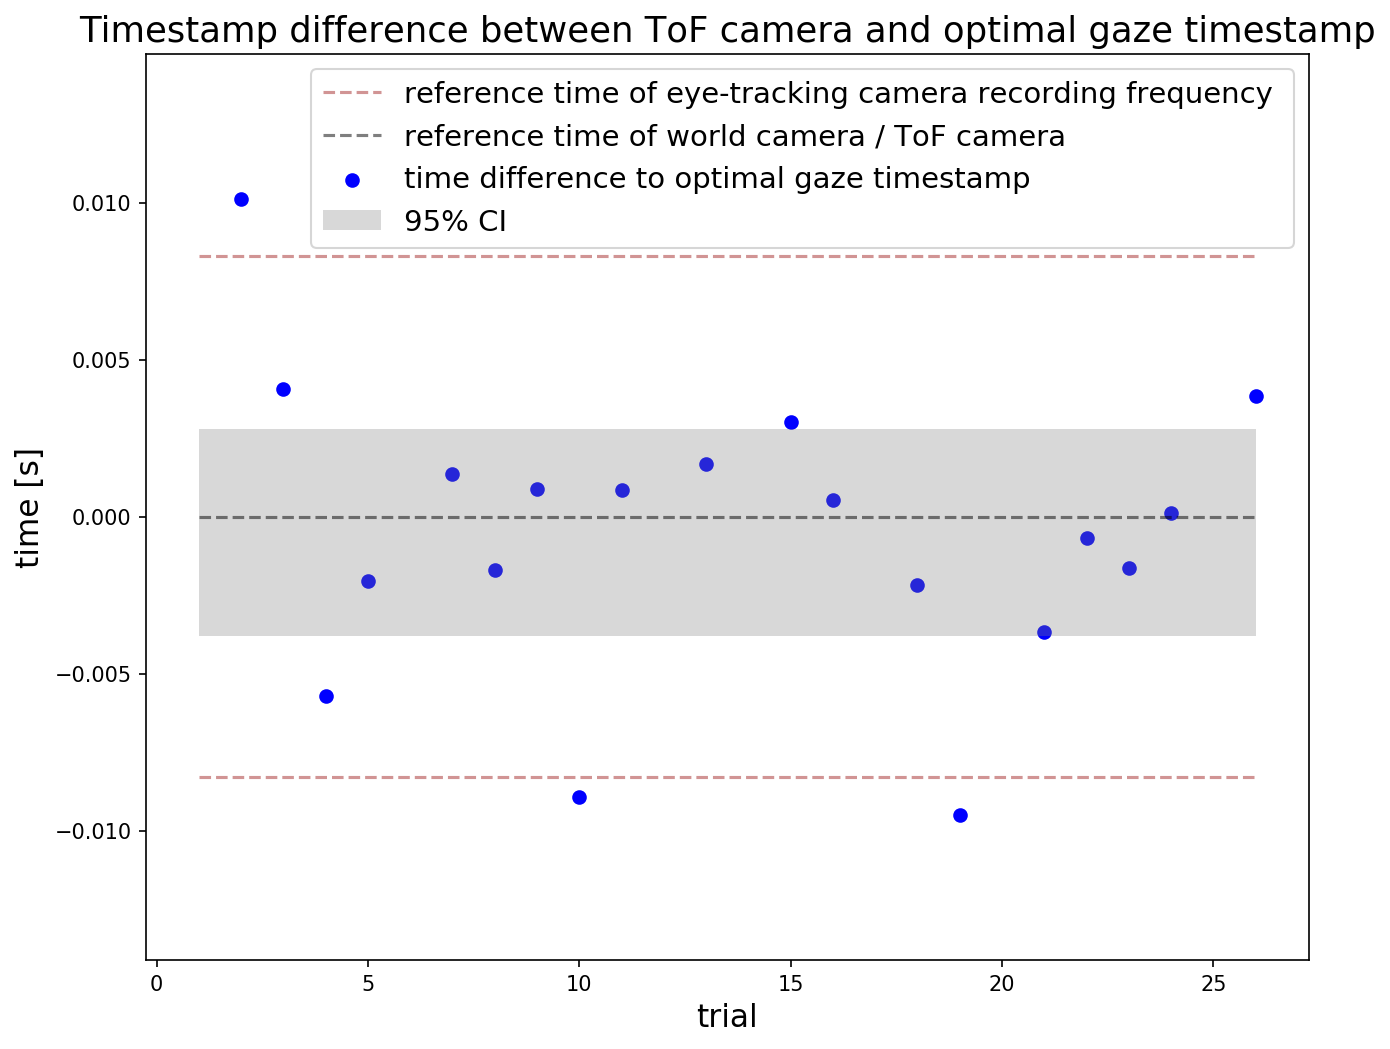

In [2]:
# # # Visualise manual data from Video frame matching of eye-tracking and world camera. 
recordings_fp = r'C:\Users\p.wagner\recordings\2020_06_26'

df = pd.read_excel (r'C:\Users\p.wagner\Documents\experiment_execution_logV.2.xlsx', sheet_name='PLPF_time_matching')
df = df.rename(columns = df.iloc[1]).drop([0, 1])
df.index -=1

for idx in df.index:
    if df.loc[idx, 'recording number'] < 10:
        recording_fp = os.path.join(recordings_fp, "00" + str(df.loc[idx, 'recording number']))
    else:
        recording_fp = os.path.join(recordings_fp,  "0" + str(df.loc[idx, 'recording number']))
    if not np.isnan(df.loc[idx, 'eye0_frame']):
        timestamps = np.load(os.path.join(recording_fp, 'world_timestamps.npy'))
        df.loc[idx, 'world_ts'] = timestamps[df.loc[idx,'world_video_frame']]
        timestamps = np.load(os.path.join(recording_fp, 'eye0_timestamps.npy'))
        df.loc[idx, 'eye0_ts'] = timestamps[df.loc[idx, 'eye0_frame']]
        timestamps = np.load(os.path.join(recording_fp, 'eye1_timestamps.npy'))
        df.loc[idx, 'eye1_ts'] = timestamps[df.loc[idx, 'eye1_frame']]

df.loc[:, 'delta_eye0_ts'] = df.loc[:, 'world_ts'] - df.loc[:, 'eye0_ts']
df.loc[:, 'delta_eye1_ts'] = df.loc[:, 'world_ts'] - df.loc[:, 'eye1_ts']
df.loc[:, 'delta_eyes_ts'] = df.loc[:, 'delta_eye0_ts'] - df.loc[:, 'delta_eye1_ts']        
df.loc[:, 'eyes_avg_ts']   = .5*(df.loc[:, 'delta_eye0_ts'] + df.loc[:, 'delta_eye1_ts'])

# 95% CI
mean = np.nanmean(df.loc[:, 'eyes_avg_ts'])
std  = np.nanstd(df.loc[:, 'eyes_avg_ts'])
n = np.isnan(df.loc[:, 'eyes_avg_ts']).sum()
z = 1.96
lower_bound = mean - z * (std / math.sqrt(n)) 
upper_bound = mean + z * (std / math.sqrt(n))

# plot figure 
fig = plt.figure(figsize=(10, 8), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(df.index, df.loc[:, 'eyes_avg_ts'], color='b', marker='o', label='time difference to optimal gaze timestamp')

plt.fill_between(df.index, lower_bound, upper_bound, facecolor='grey', alpha=0.3, label='95% CI')

# plt.scatter(df.loc[:, 'recording number'], df.loc[:, 'delta_eye1_ts'], color='green', marker='o')
# plt.scatter(df.loc[:, 'recording number'], df.loc[:, 'delta_eyes_ts'], color='r', marker='x')
plt.plot([1, 26], [.0083, .0083], c='brown', linestyle='--', alpha= .5, label='reference time of eye-tracking camera recording frequency ')
plt.plot([1, 26], [-.0083, -.0083], c='brown', linestyle='--', alpha= .5)
plt.plot([1, 26], [0, 0], c='k', linestyle='--', alpha= .5, label='reference time of world camera / ToF camera')
plt.title('Timestamp difference between ToF camera and optimal gaze timestamp', fontsize=17)
plt.xlabel('trial', fontsize=15)
plt.ylabel('time [s]',  fontsize=15)
plt.legend( fontsize=14)
plt.show()

In [3]:
df.head()


,recording number,world_video_frame,eye0_frame,eye1_frame,nan,reason,world_ts,eye0_ts,eye1_ts,delta_eye0_ts,delta_eye1_ts,delta_eyes_ts,eyes_avg_ts
1,21,2,NaN,NaN,NaN,too far dwon,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22,4,99,96,NaN,NaN,202993.357256,202993.347686,202993.346611,0.009570,0.010645,-0.001075,0.010107
3,23,3,68,69,NaN,NaN,202999.561217,202999.557931,202999.556347,0.003286,0.004870,-0.001584,0.004078
4,24,2,47,50,NaN,NaN,203005.565200,203005.578503,203005.563345,-0.013303,0.001855,-0.015158,-0.005724
5,25,3,77,76,NaN,NaN,203012.169185,203012.174277,203012.168203,-0.005092,0.000982,-0.006074,-0.002055


In [4]:
sample_1 = df.eyes_avg_ts.dropna()

mean_s1 = np.nanmean(sample_1)
std_s1  = np.nanstd(sample_1)
n_s1    = sample_1.shape[0]

mean_s1, std_s1, n_s1


(-0.0005058968113428962, 0.004446743161933329, 19)

Text(0, 0.5, 'time [s]')

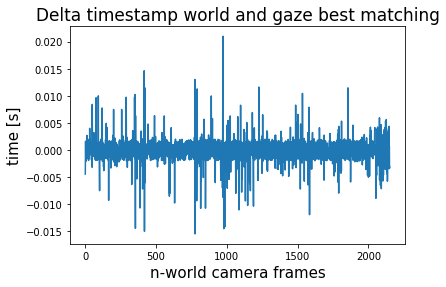

In [5]:
# # from sample recording take world camera timestamps match with closest gaze timestamp 

recording_fp = r'C:\Users\p.wagner\recordings\2020_04_10\001'
sample = pd.DataFrame(columns=['world_ts'])
sample.loc[:,'world_ts'] = np.load(os.path.join(recording_fp, 'world_timestamps.npy'))

# drop data that could not be matched 
sample = sample[:-7]
gaze_ts = np.load(os.path.join(recording_fp, 'gaze_timestamps.npy'))


for idx in sample.index: 
    sample.loc[idx, 'gaze_ts_prior'] = gaze_ts[gaze_ts < sample.loc[idx, 'world_ts']][-1]
    sample.loc[idx, 'gaze_ts_post'] = gaze_ts[gaze_ts > sample.loc[idx, 'world_ts']][0]

sample.loc[:, 'delta_ts_prior'] = sample.loc[:, 'world_ts'] - sample.loc[:, 'gaze_ts_prior']
sample.loc[:, 'delta_ts_post'] = sample.loc[:, 'world_ts'] - sample.loc[:, 'gaze_ts_post']

for idx in sample.index:     
    if abs(sample.loc[idx, 'delta_ts_post']) < abs(sample.loc[idx, 'delta_ts_prior']):
        sample.loc[idx, 'delta_min'] = sample.loc[idx, 'delta_ts_post']

    else: 
        sample.loc[idx, 'delta_min'] = sample.loc[idx, 'delta_ts_prior']
    
plt.plot(sample.delta_min)
plt.title('Delta timestamp world and gaze best matching', fontsize=17)
plt.xlabel('n-world camera frames', fontsize=15)
plt.ylabel('time [s]',  fontsize=15)


In [6]:
sample_manual = df.eyes_avg_ts.dropna()

mean_s1 = np.nanmean(sample_manual)
std_s1  = np.nanstd(sample_manual, ddof=1) # doff=1 for sample std
n_s1    = sample_manual.shape[0]

mean_s1, std_s1, n_s1

(-0.0005058968113428962, 0.004568594302504727, 19)

In [7]:
mean1 = np.nanmean(sample.loc[:, 'delta_min'])
std1  = np.nanstd(sample.loc[:, 'delta_min'], ddof=1)
n1    = sample.shape[0]

mean1, std1, n1

(-0.00010879000082203333, 0.002368130864749074, 2151)

In [8]:
mean2 = np.nanmean(sample.loc[:, 'delta_ts_post'])
std2  = np.nanstd(sample.loc[:, 'delta_ts_post'], ddof=1)
n2    = sample.shape[0]

mean2, std2, n2

(-0.0028991444871078477, 0.004315189067664281, 2151)

In [9]:
mean3 = np.nanmean(sample.loc[:, 'delta_ts_prior'])
std3  = np.nanstd(sample.loc[:, 'delta_ts_prior'], ddof=1)
n3    = sample.shape[0]

mean3, std3, n3

(0.0030110640205630213, 0.0037393233947890635, 2151)

In [13]:
sample_manual .to_csv(os.path.join(r'C:\Users\p.wagner\Documents\phd\output', 'gaze_timestamps_manual_sample.csv'), 
                      index = False, header = False)
sample.delta_min.to_csv(os.path.join(r'C:\Users\p.wagner\Documents\phd\output', 'sample.csv'), 
                        index = False, header = False)                

In [15]:
stats.normaltest(sample_manual, axis=0, nan_policy='omit')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


NormaltestResult(statistic=1.3455437244396757, pvalue=0.5102921560820041)

(array([2., 1., 1., 3., 3., 5., 3., 0., 0., 1.]),
 array([-0.0094953 , -0.00753505, -0.0055748 , -0.00361455, -0.0016543 ,
         0.00030595,  0.0022662 ,  0.00422645,  0.0061867 ,  0.00814695,
         0.0101072 ]),
 <a list of 10 Patch objects>)

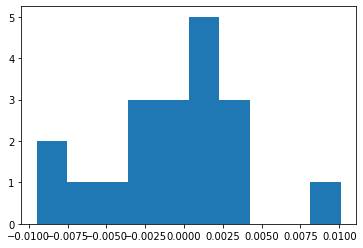

In [16]:
plt.hist(sample_manual)


In [17]:
stats.normaltest(sample.delta_ts_post, axis=0, nan_policy='omit')

NormaltestResult(statistic=3988.8486181381586, pvalue=0.0)

(array([  1.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   2.,   2.,   2.,   1.,   2.,   1.,   2.,   1.,   3.,   4.,
          4.,   4.,   4.,   4.,   6.,  13.,   4.,   8.,   6.,   7.,  14.,
         18.,  13.,  16.,  27., 163., 155., 177., 195., 169., 161., 199.,
        166., 161., 189., 113.,  21.,  13.,   9.,  11.,  10.,  12.,   6.,
          6.,   3.,   3.,   4.,   5.,   2.,   1.,   2.,   1.,   1.,   3.,
          0.,   1.,   1.,   4.,   1.,   1.,   0.,   3.,   1.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.01548333, -0.0151185 , -0.01475367, -0.01438884, -0.01402401,
        -0.01365918, -0.01329435, -0.01292952, -0.0125647 , -0.01219987,
        -0.01183504, -0.01147021, -0.01110538, -0.01074055, -0.01037572,
        -0.01001089, -0.00964606, -0.00928123, -0.0089164 , -0.00855157,
        -0.00818674, -0.00

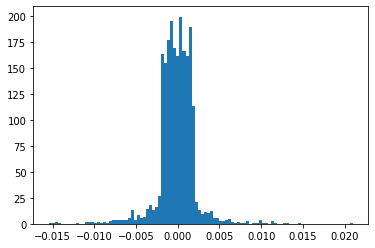

In [18]:
plt.hist(sample.delta_min, bins=100)

In [19]:
stats.mannwhitneyu(sample_1, sample.delta_min)

MannwhitneyuResult(statistic=19509.0, pvalue=0.36686147392337437)

In [20]:
sample.head()

,world_ts,gaze_ts_prior,gaze_ts_post,delta_ts_prior,delta_ts_post,delta_min
0,570.475766,570.468241,570.480206,0.007525,-0.004440,-0.004440
1,570.676309,570.672319,570.676365,0.003989,-0.000056,-0.000056
2,570.876357,570.874734,570.878718,0.001623,-0.002361,0.001623
3,571.076970,571.069103,571.077812,0.007866,-0.000842,-0.000842
4,571.277213,571.276348,571.280357,0.000865,-0.003144,0.000865
